# Hamiltonian simulation with Gray code encoding - QASM simulator

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm

from pprint import pprint
from tqdm import tqdm

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.compiler import transpile

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from device import Device
from qiskit_circuits import *

## Simulation

In [2]:
# Perform unitary evolution 
def unitary_evolution(ham, t):
    return expm(-1j * ham * t)

# Basis states for the two systems
states_gc = ['00', '10', '11', '01']
states_oh = ['1000', '0100', '0010', '0001']

colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

In [3]:
# Arbitrary simulation time
T = 1

# Range of Trotter steps to use
min_trotter_steps = 1
max_trotter_steps = 100

H_gc = DenseEncodingHamiltonian(N_states=4)

backend = Aer.get_backend('qasm_simulator')

# Not using the device in this simulation, but need it to get the basis gates for transpilation
# Set the IBM Q device noise model
device = Device('ibmq_vigo', mitigate_meas_error=False, N_qubits=5)

In [4]:
# Get the matrix in "qiskit order"
gc_ham_rep = reduce(lambda x, y: x + y, [p[1] * get_pauli_matrix(p[0]) for p in H_gc.pauli_coeffs.items()])
uniform_superposition_gc = 0.5 * np.array([[1], [1], [1], [1]])

wavefunction = unitary_evolution(gc_ham_rep, t=T) @ uniform_superposition_gc
true_probabilities = (wavefunction * np.conj(wavefunction)).flatten().real

true_results_gc = {'00' : true_probabilities[0],
                   '10' : true_probabilities[1],
                   '11' : true_probabilities[3],
                   '01' : true_probabilities[2]
                  }

exact_wavefunction_gc = unitary_evolution(gc_ham_rep, t=T) @ uniform_superposition_gc

This code loops over the different numbers of Trotter steps and performs the evolution by running the circuit using the statevector simulator.

In [5]:
weighted_paulis = [(v, Pauli.from_label(k)) for (k, v) in list(H_gc.pauli_coeffs.items())]
my_pauli = WeightedPauliOperator(weighted_paulis)

results_dicts_gc = []

# Loop through different levels of optimization
for opt_level in range(4):
    results_dict_gc = {x : np.zeros(max_trotter_steps) for x in states_gc}
    
    for n_trotter_steps in tqdm(range(min_trotter_steps, max_trotter_steps + 1)):
        # Prepare and run the evolution circuit
        q = QuantumRegister(H_gc.N_qubits)
        c = ClassicalRegister(H_gc.N_qubits)
        circuit = QuantumCircuit(q, c)

        circuit.h(q)

        circuit += my_pauli.evolve(
            None, evo_time=T, num_time_slices=n_trotter_steps,
            quantum_registers=q,
            expansion_mode='trotter'
        )

        circuit.measure(q, c)

        optimized_circuit = transpile(circuit, 
                                      backend=backend,
                                      basis_gates=device.noise_model.basis_gates,
                                      initial_layout=[2, 1],
                                      optimization_level=opt_level)

        # Get and process results for the optimized circuit
        job = execute(optimized_circuit, backend, shots=10000)

        results = job.result().get_counts(circuit)

        for state in results_dict_gc.keys():
            if state[::-1] in results.keys():
                results_dict_gc[state[::-1]][n_trotter_steps-1] = results[state]/10000
                
    results_dicts_gc.append(results_dict_gc)

100%|██████████| 100/100 [00:29<00:00,  3.43it/s]


In [6]:
print(f"True state probabilities:")
for state in states_gc:
    print(f"{state}: {true_results_gc[state].real}")
print()
print(f"State probabilities at {max_trotter_steps} Trotter steps:")
for state in states_gc:
    print(f"{state}: {results_dict_gc[state][-1]}")

True state probabilities:
00: 0.644890158887242
10: 0.050270303872851696
11: 0.18661786653005275
01: 0.11822167070985606

State probabilities at 100 Trotter steps:
00: 0.6575
10: 0.0416
11: 0.1817
01: 0.1192


Now we'll do the same thing for one-hot. We'll prepare the uniform superposition here by running the variational ansatz with the set of parameters that will produce it.

In [7]:
H_oh = SparseEncodingHamiltonian(N_states=4, qiskit_order=True)
oh_ham_rep = reduce(lambda x, y: x + y, [p[1] * get_pauli_matrix(p[0]) for p in H_oh.pauli_coeffs.items()])
uniform_oh = 0.5 * np.array([[0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0]]).reshape((16, 1))

exact_wavefunction_oh = unitary_evolution(oh_ham_rep, t=T) @ uniform_oh

true_probabilities = (exact_wavefunction_oh * np.conj(exact_wavefunction_oh)).flatten()

true_results_oh = {'1000' : true_probabilities[1],
                   '0100' : true_probabilities[2],
                   '0010' : true_probabilities[4],
                   '0001' : true_probabilities[8]}

In [8]:
weighted_paulis = [(v, Pauli.from_label(k)) for (k, v) in list(H_oh.pauli_coeffs.items())]
my_pauli = WeightedPauliOperator(weighted_paulis)

# To prepare the uniform superposition, run the sparse variational ansatz with the following parameters
θ_1 = 2 * np.pi / 3
θ_2 = 2 * np.arccos(1/np.sqrt(3)) 
θ_3 = 2 * np.arccos(1/(np.sqrt(3) * np.sin(θ_2 / 2)))
params = [θ_1, θ_2, θ_3]

results_dicts_oh = []

for opt_level in range(4):
    results_dict_oh = {x : np.zeros(max_trotter_steps) for x in states_oh}

    for n_trotter_steps in tqdm(range(min_trotter_steps, max_trotter_steps+1)):
        # Construct uniform superposition over spherical coordinates
        q = QuantumRegister(H_oh.N_qubits)
        c = ClassicalRegister(H_oh.N_qubits)

        circuit = QuantumCircuit(q, c)

        circuit.x(q[0])
        circuit.ry(θ_1, q[1])
        circuit.cx(q[1], q[0])
        circuit.cry(θ_2, q[1], q[2])
        circuit.cx(q[2], q[1])
        circuit.cry(θ_3, q[2], q[3])
        circuit.cx(q[3], q[2])

        circuit += my_pauli.evolve(
            None, evo_time=T, num_time_slices=n_trotter_steps,
            quantum_registers=q,
            expansion_mode='trotter'
        )

        circuit.measure(q, c)

        optimized_circuit = transpile(circuit, 
                                      backend=backend,
                                      basis_gates=device.noise_model.basis_gates,
                                      initial_layout=[2, 1, 3, 4],
                                      optimization_level=opt_level)

        # Get and process results for the optimized circuit
        job = execute(optimized_circuit, backend, shots=10000)

        results = job.result().get_counts(circuit)

        for state in results_dict_oh.keys():
            if state[::-1] in results.keys():
                results_dict_oh[state[::-1]][n_trotter_steps-1] = results[state]/10000
                
    results_dicts_oh.append(results_dict_oh)

100%|██████████| 100/100 [04:49<00:00,  2.90s/it]


In [9]:
print(f"True state probabilities:")
for state in states_oh:
    print(f"{state}: {true_results_oh[state].real}")
print()
print(f"State probabilities at {max_trotter_steps} Trotter steps:")
for state in states_oh:
    print(f"{state}: {results_dict_oh[state][-1]}")

True state probabilities:
1000: 0.6448901588872414
0100: 0.05027030387285137
0010: 0.18661786653005197
0001: 0.11822167070985556

State probabilities at 100 Trotter steps:
1000: 0.6655
0100: 0.0408
0010: 0.1748
0001: 0.1189


Let's plot it all together...

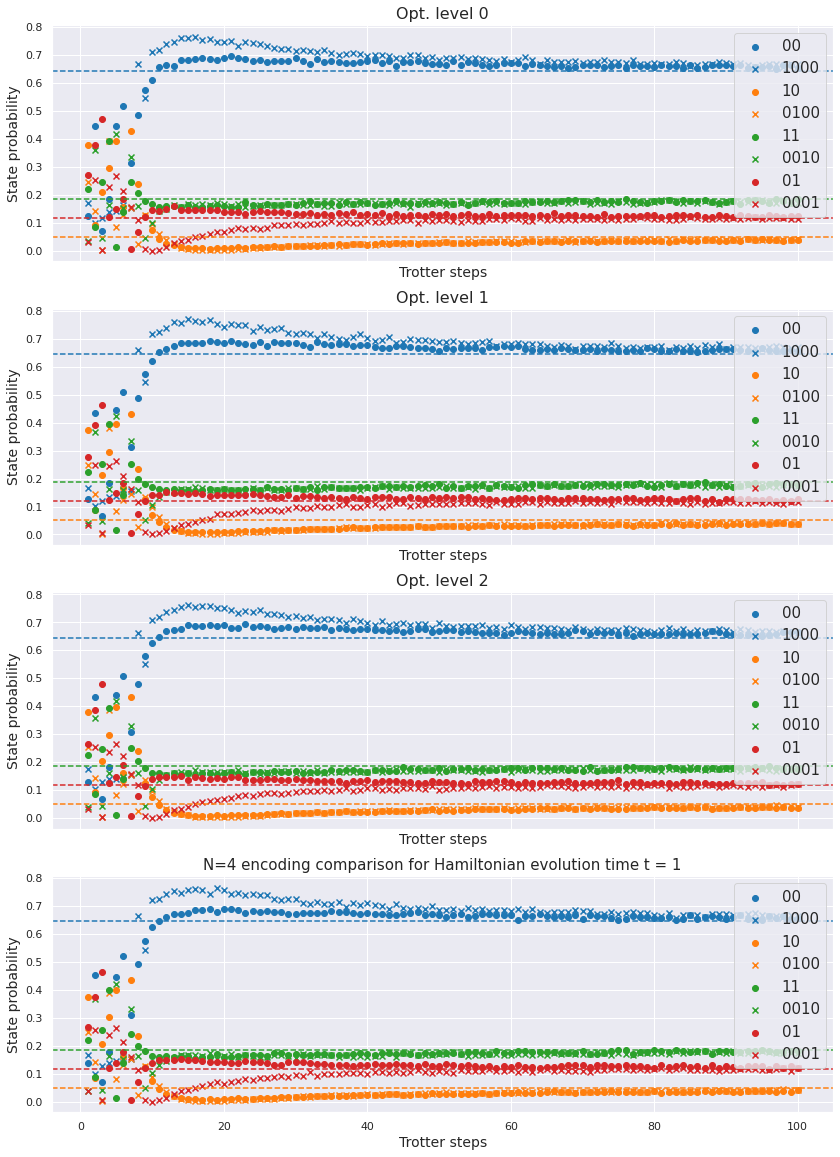

In [10]:
fig, ax = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(14, 20))

# Plot in subplots
for opt_level in range(4):    
    colour_idx = 0

    with sns.axes_style("whitegrid"):
        for state_gc, state_oh in zip(states_gc, states_oh):
            ax[opt_level].scatter(x=range(min_trotter_steps, max_trotter_steps+1), 
                        y=results_dicts_gc[opt_level][state_gc], label=state_gc, color=colours[colour_idx])
            ax[opt_level].scatter(x=range(min_trotter_steps, max_trotter_steps+1), 
                        y=results_dicts_oh[opt_level][state_oh], label=state_oh, color=colours[colour_idx], marker='x')
            ax[opt_level].axhline(y=true_results_oh[state_oh], color=colours[colour_idx], linestyle='dashed')
            colour_idx += 1

    ax[opt_level].set_xlabel("Trotter steps", fontsize=14)
    ax[opt_level].set_ylabel("State probability", fontsize=14)
    ax[opt_level].set_title(f"Opt. level {opt_level}", fontsize=16)
    
    ax[opt_level].legend(fontsize=15)   
    
plt.title(f"N=4 encoding comparison for Hamiltonian evolution time t = {T}", fontsize=15);
